In [104]:
import pandas as pd
import datetime as dt
from math import sqrt
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [120]:
import time
import cbpro
import csv
import json
import shutil
import os
from dateutil.relativedelta import relativedelta
start_time = dt.datetime.now()
end_time = start_time-relativedelta(years=1)
public_client = cbpro.PublicClient()
public_client.get_product_historic_rates('ETH-USD')
data = public_client.get_product_historic_rates('ETH-USD', granularity=21600)

In [121]:
print(data)

[[1559930400, 247, 254, 253.45, 249.88, 28284.32873722], [1559908800, 246.23, 254.4, 247.7, 253.41, 36039.82610055], [1559887200, 246.84, 250.42, 246.85, 247.7, 21599.88583113], [1559865600, 244.84, 252, 249.54, 246.85, 28222.52134718], [1559844000, 235.32, 251.29, 241.42, 249.4, 67859.41460367], [1559822400, 241.03, 247.1, 246.63, 241.43, 32026.72799869], [1559800800, 242.11, 247.31, 245.49, 246.79, 13615.77809268], [1559779200, 244.6, 247.72, 246.28, 245.37, 14318.39035508], [1559757600, 241.53, 249, 246.06, 246.32, 47247.33629074], [1559736000, 237.55, 247.52, 245.2, 246.04, 39630.51212289], [1559714400, 241.16, 248, 242.23, 245.15, 21631.69055893], [1559692800, 239.84, 243.73, 240.95, 242.18, 31907.59186416], [1559671200, 233, 243.52, 239.22, 240.93, 71738.07831279], [1559649600, 236.46, 250.99, 245.09, 239.17, 55507.98210778], [1559628000, 241.7, 248.09, 245.73, 245.15, 21208.83903654], [1559606400, 237, 249.43, 249.4, 245.5, 89412.39074631], [1559584800, 246.6, 261.9, 258.87, 249

In [122]:
data1 = data1.iloc[::-1]
data1 = data1.reset_index()
data1 = data1.drop(['index',0],axis=1)
print(data1)

          1       2       3       4            5
0    242.80  243.25  243.24  243.25   248.426268
1    242.97  243.59  243.24  243.16   336.758746
2    243.02  243.42  243.09  243.12   144.217616
3    242.93  243.26  243.17  243.09   192.359174
4    242.61  243.35  243.25  242.89    76.474006
5    242.25  243.07  242.87  242.25    73.848296
6    241.92  242.60  242.21  242.07   340.485330
7    241.03  242.51  242.17  242.31   922.961370
8    242.28  242.85  242.42  242.28   350.428634
9    242.26  242.69  242.32  242.26   130.480764
10   241.87  242.68  242.39  242.61   249.493549
11   242.36  242.88  242.70  242.54   371.368710
12   241.76  242.33  242.33  242.09   229.119775
13   241.92  242.36  242.19  242.00   137.073222
14   241.23  242.19  242.19  241.43   278.848232
15   240.80  241.73  241.42  240.80   538.925904
16   238.90  240.95  240.95  239.48  2975.142356
17   236.54  239.62  239.44  238.57  4189.786970
18   237.89  239.70  238.57  239.11  2708.063983
19   236.19  238.99 

In [123]:
data1.to_csv('data.csv')

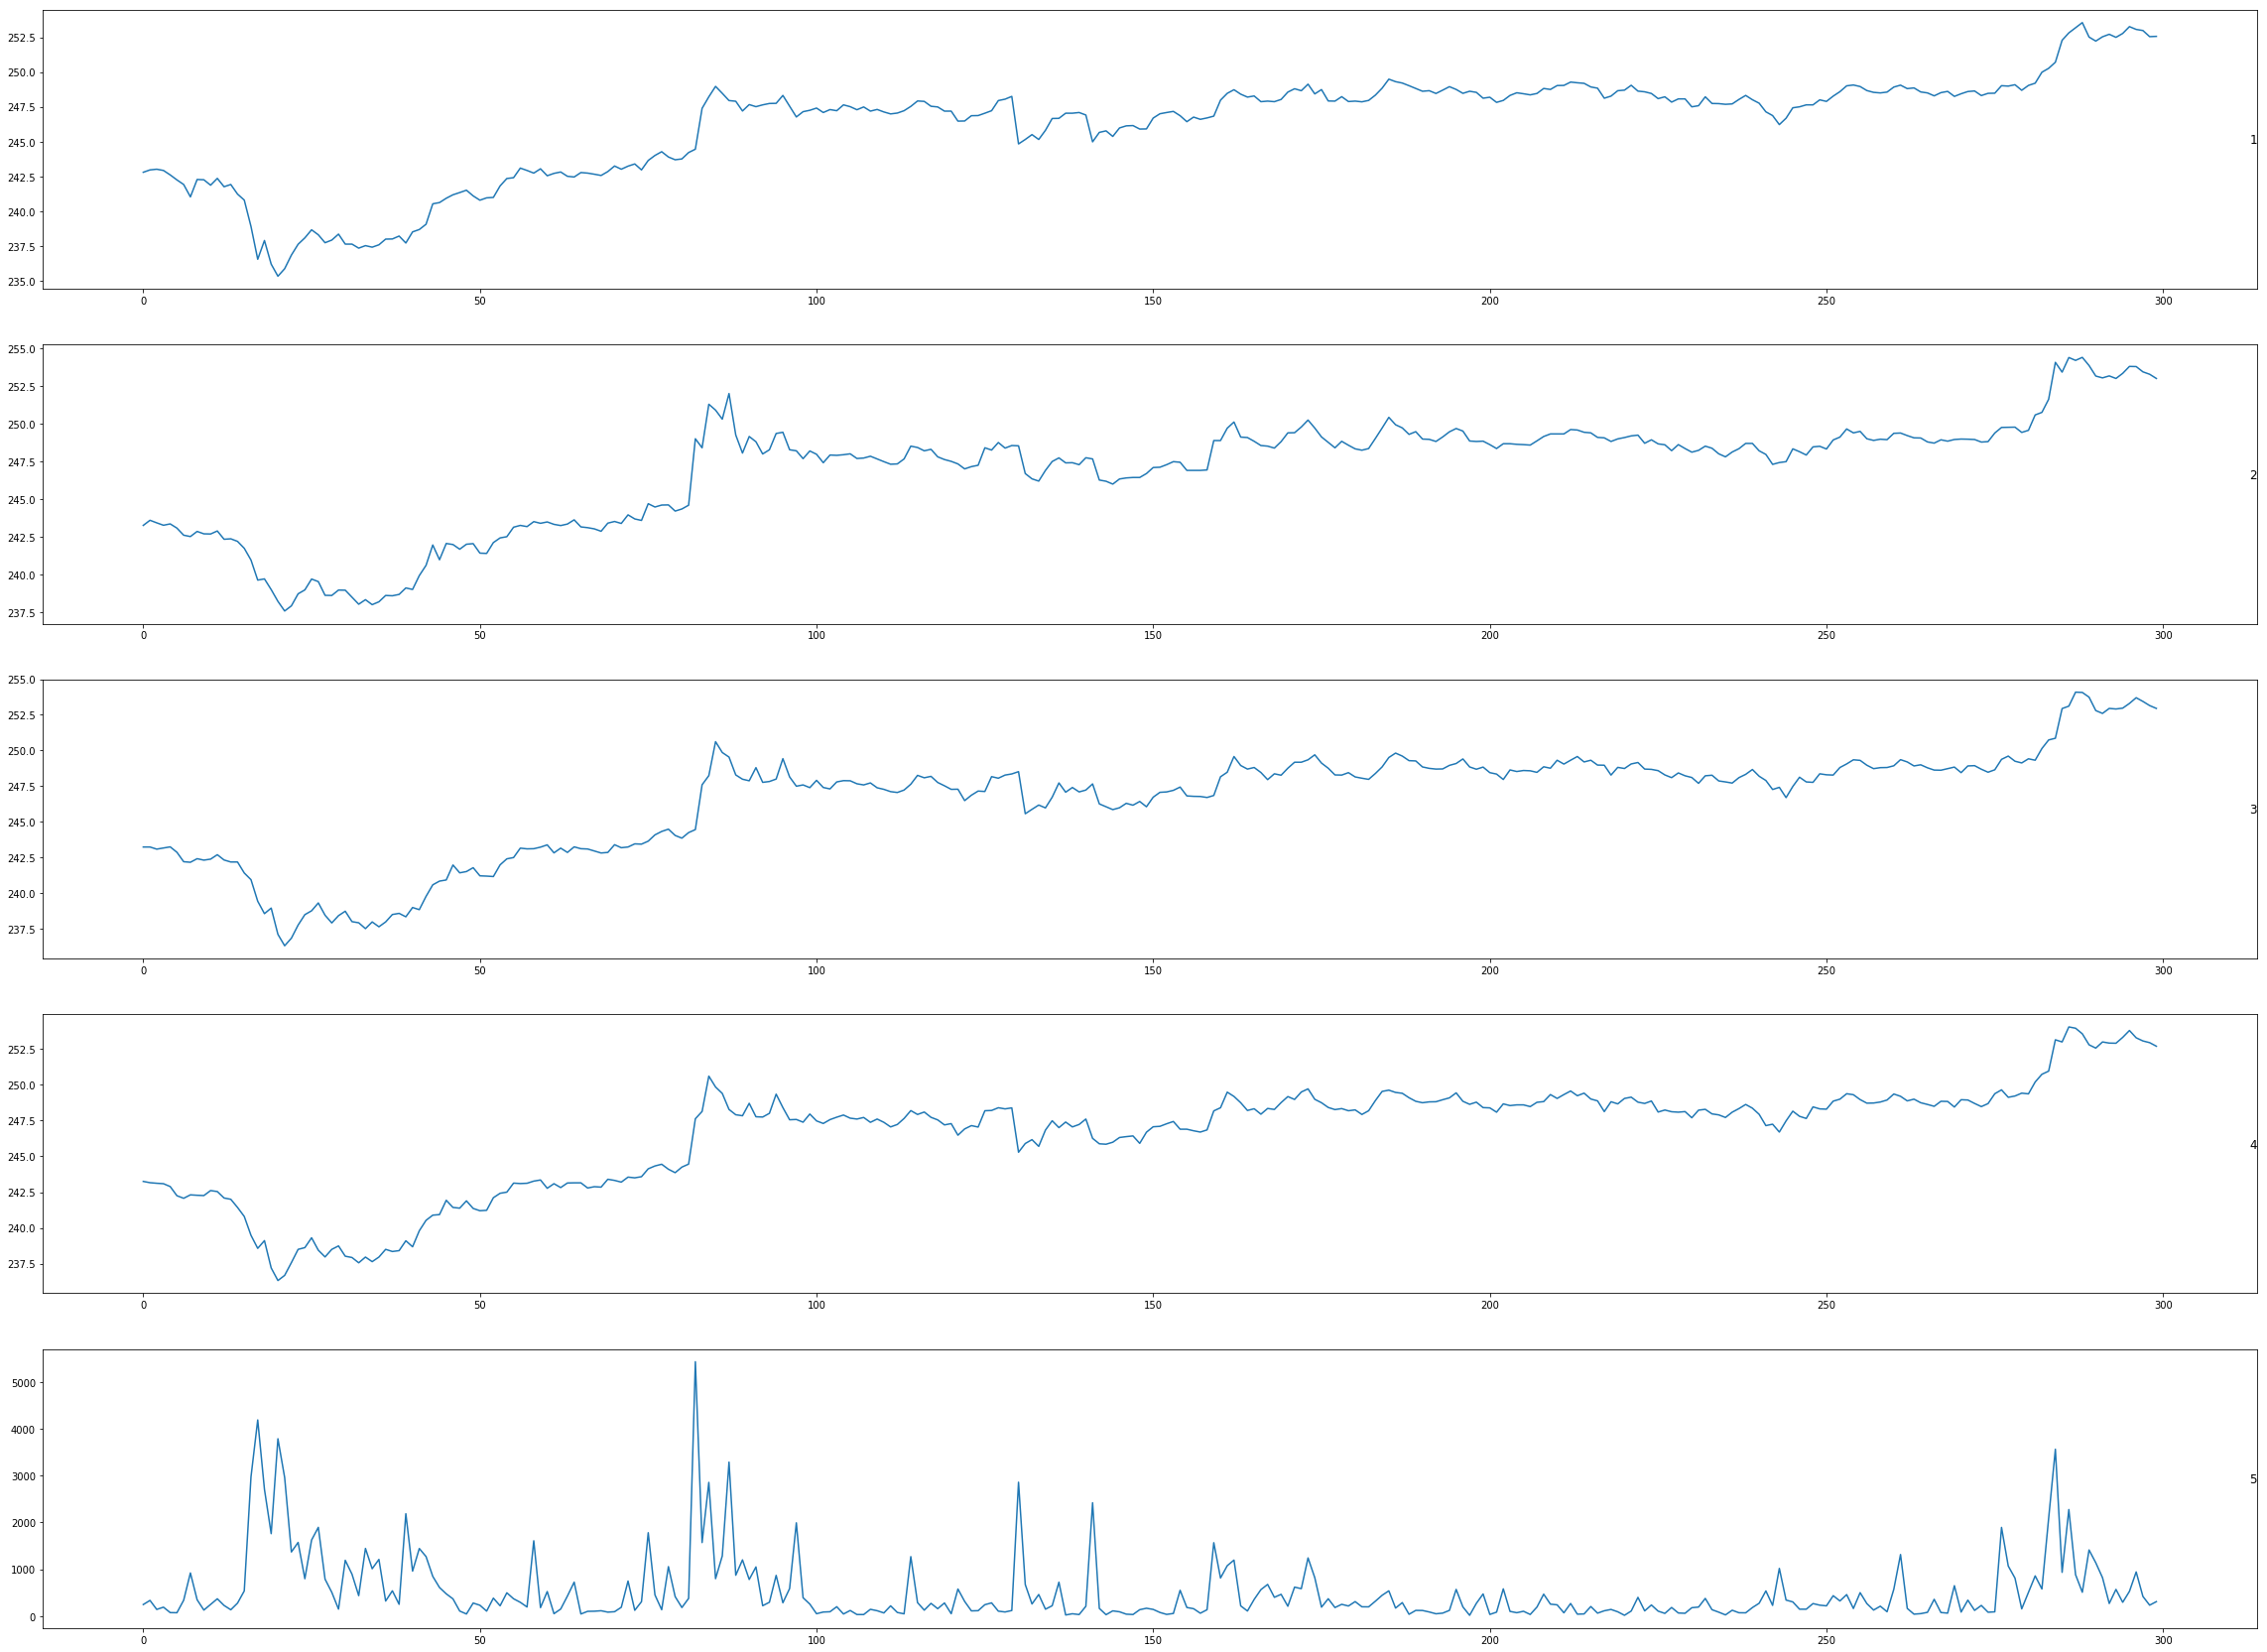

In [124]:
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline
# load dataset
dataset = read_csv('data.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0,1,2,3,4]
i = 1
# plot each column
pyplot.figure(figsize=(40,30))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [125]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
## load dataset
dataset = read_csv('data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7,9]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var4(t)
1   0.409863   0.337493   0.389421   0.390862   0.491639  0.385786
2   0.419178   0.357695   0.389421   0.385786   0.598662  0.383530
3   0.421918   0.347593   0.380979   0.383530   0.314381  0.381838
4   0.416986   0.338086   0.385481   0.381838   0.394649  0.370558
5   0.399451   0.343434   0.389983   0.370558   0.137124  0.334460


In [126]:
# split into train and test sets
values = reframed.values
n_train_hours = 290
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(290, 1, 5) (290,) (9, 1, 5) (9,)


In [127]:
print(test_y)

[0.9407778  0.93626595 0.9357014  0.958827   0.985899   0.95713425
 0.944726   0.93795776 0.92385674]


Train on 290 samples, validate on 9 samples
Epoch 1/50
 - 6s - loss: 0.5620 - val_loss: 0.9225
Epoch 2/50
 - 0s - loss: 0.5397 - val_loss: 0.8940
Epoch 3/50
 - 0s - loss: 0.5138 - val_loss: 0.8575
Epoch 4/50
 - 0s - loss: 0.4808 - val_loss: 0.8074
Epoch 5/50
 - 0s - loss: 0.4375 - val_loss: 0.7366
Epoch 6/50
 - 0s - loss: 0.3805 - val_loss: 0.6352
Epoch 7/50
 - 0s - loss: 0.3043 - val_loss: 0.4881
Epoch 8/50
 - 0s - loss: 0.1996 - val_loss: 0.2765
Epoch 9/50
 - 0s - loss: 0.0838 - val_loss: 0.0208
Epoch 10/50
 - 0s - loss: 0.1539 - val_loss: 0.0750
Epoch 11/50
 - 0s - loss: 0.1412 - val_loss: 0.0806
Epoch 12/50
 - 0s - loss: 0.1006 - val_loss: 0.2005
Epoch 13/50
 - 0s - loss: 0.1074 - val_loss: 0.1900
Epoch 14/50
 - 0s - loss: 0.0864 - val_loss: 0.1070
Epoch 15/50
 - 0s - loss: 0.0765 - val_loss: 0.0483
Epoch 16/50
 - 0s - loss: 0.0857 - val_loss: 0.0821
Epoch 17/50
 - 0s - loss: 0.0775 - val_loss: 0.0846
Epoch 18/50
 - 0s - loss: 0.0743 - val_loss: 0.0626
Epoch 19/50
 - 0s - loss: 0.0

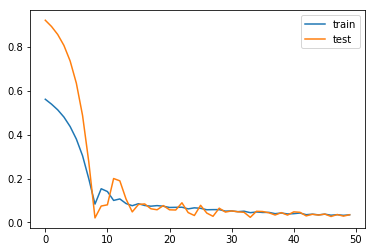

In [128]:
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [129]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.748


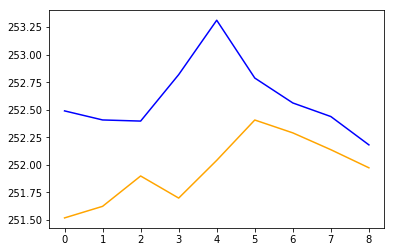

In [130]:
pyplot.plot(inv_yhat,color='orange')
pyplot.plot(inv_y,color='b')
pyplot.show()

In [131]:
inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print(inv_yhat)

            0
0  251.516830
1  251.622025
2  251.897827
3  251.697006
4  252.039902
5  252.406326
6  252.289429
7  252.136536
8  251.972137


In [132]:
udyhat=[]
for i in range(1,len(inv_yhat)):
    if inv_yhat[0][i] > inv_yhat[0][i-1]:
        udyhat.append(1)
    else:
        udyhat.append(0)
udy = []
for i in range(1,len(inv_y)):
    if inv_y[0][i] > inv_y[0][i-1]:
        udy.append(1)
    else:
        udy.append(0)
print(udy,udyhat)

[0, 0, 1, 1, 0, 0, 0, 0] [1, 1, 0, 1, 1, 0, 0, 0]


In [133]:
udy = pd.DataFrame(udy)
udyhat = pd.DataFrame(udyhat)
ud = pd.concat([udy,udyhat],axis=1)
print(ud)

   0  0
0  0  1
1  0  1
2  1  0
3  1  1
4  0  1
5  0  0
6  0  0
7  0  0


In [134]:
ud['truths'] = udy == udyhat


In [135]:
accuracy = print(sum(ud['truths'])/len(ud['truths'])*100,'%')

50.0 %
